# 125. Malware Detection - binary classification

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
df = pd.read_csv('sample_data/malware.csv', index_col=0)
df.head()

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
65416,VirusShare_3ede9b62781398a2e39a0f6af9356a54,3ede9b62781398a2e39a0f6af9356a54,332,224,258,10,0,117760,392192,0,...,5,3.425849,2.458492,4.035538,3146.400000,48,9640,72,15,0
23220,fxsocm.dll,9a0959a682d8eba06d0bd181c49ee2a8,332,224,8462,7,10,112640,29696,0,...,8,3.911994,2.669737,5.335373,1222.750000,164,4889,72,16,1
118017,VirusShare_abe7101746242c922a539ba461db4e38,abe7101746242c922a539ba461db4e38,332,224,258,10,0,119808,385024,0,...,6,3.776760,2.458492,5.317552,2740.166667,48,9640,72,15,0
69842,VirusShare_64a1247fc96d5bc2994ef89ca09adee8,64a1247fc96d5bc2994ef89ca09adee8,332,224,258,10,0,120320,385024,0,...,6,3.756068,2.458492,5.317552,2739.500000,48,9640,72,15,0
22165,asferror.dll,ebc23440aa9cc4f08241d35147c1d5b5,332,224,8462,7,10,0,7168,0,...,2,3.488703,3.471506,3.505901,3050.000000,888,5212,0,16,1


In [5]:
df.shape

(10000, 57)

In [6]:
df['legitimate'].value_counts()

0    7071
1    2929
Name: legitimate, dtype: int64

In [7]:
df.columns

Index(['Name', 'md5', 'Machine', 'SizeOfOptionalHeader', 'Characteristics',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase',
       'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion',
       'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion',
       'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfImage',
       'SizeOfHeaders', 'CheckSum', 'Subsystem', 'DllCharacteristics',
       'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve',
       'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'SectionsNb',
       'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy',
       'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize',
       'SectionsMeanVirtualsize', 'SectionsMinVirtualsize',
       'SectionMaxVirtualsize', 'ImportsNbDLL', 'ImportsNb',
       'Impor

- Name : 제외
- md5 : hash value 제외

In [8]:
df = df.iloc[:, 2:]

df.shape

(10000, 55)

In [9]:
y = df.pop('legitimate').values
X = df.values

- Train, Test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 54), (2000, 54), (8000,), (2000,))

In [11]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [13]:
# PyTorch의 FloatTensor로 변환
X_train_ts = torch.FloatTensor(X_train)
X_test_ts = torch.FloatTensor(X_test)

# view(-1, 1)을 사용하여 [N, 1] 형태의 열 벡터로 재구성
y_train_ts = torch.FloatTensor(y_train).view(-1, 1)
y_test_ts = torch.FloatTensor(y_test).view(-1, 1)

## ``nn.Module``을 이용한 사용자 정의 Logistic Regression model 정의

In [14]:
# nn.Module을 상속받아 사용자 정의 로지스틱 회귀 모델 클래스를 정의
class LogisticReg(nn.Module):
    def __init__(self, in_dim):
        super(LogisticReg, self).__init__()
        self.linear1 = nn.Linear(in_dim, 32)
        self.linear2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 첫 번째 선형 레이어를 통과시킨 후, ReLU 활성화 함수를 적용
        x = self.relu(self.linear1(x))
        # 그 다음, 두 번째 선형 레이어를 통과시킨 후, 시그모이드 활성화 함수를 적용
        out = self.sigmoid(self.linear2(x))
        return out

In [15]:
model = LogisticReg(X_train.shape[1]).to(device)

# random 하게 초기화 된 parameter 출력
print(model)

LogisticReg(
  (linear1): Linear(in_features=54, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [16]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### dataset loader 생성

In [17]:
# torch.utils.data.TensorDataset을 사용하여 학습 데이터셋을 생성
train_ds = torch.utils.data.TensorDataset(X_train_ts, y_train_ts)

# 학습 데이터셋을 DataLoader에 전달하여 학습 데이터 로더를 생성
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)

# 생성한 Neural Network Model Train

In [18]:
# 손실값을 저장할 리스트 초기화
Loss = []

num_epochs = 50

for epoch in range(num_epochs):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        # 모델에 입력 데이터를 전달하여 예측값 계산
        yhat = model(x)
        # 예측값과 실제 레이블 사이의 손실 계산
        loss = criterion(yhat, y)

        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()
        # 손실에 대한 역전파 수행 및 기울기 계산
        loss.backward()
        # 계산된 기울기를 사용하여 모델의 파라미터 업데이트
        optimizer.step()

    # 현재 에포크의 손실값 출력
    print("epoch {} loss: {:.4f}".format(epoch + 1, loss.item()))
    # 손실값을 Loss 리스트에 추가
    Loss.append(loss.item())

epoch 1 loss: 0.5583
epoch 2 loss: 0.4386
epoch 3 loss: 0.3274
epoch 4 loss: 0.2414
epoch 5 loss: 0.1942
epoch 6 loss: 0.1484
epoch 7 loss: 0.1466
epoch 8 loss: 0.1186
epoch 9 loss: 0.1102
epoch 10 loss: 0.0813
epoch 11 loss: 0.1034
epoch 12 loss: 0.0779
epoch 13 loss: 0.0671
epoch 14 loss: 0.0663
epoch 15 loss: 0.0417
epoch 16 loss: 0.0514
epoch 17 loss: 0.0499
epoch 18 loss: 0.0748
epoch 19 loss: 0.0680
epoch 20 loss: 0.0554
epoch 21 loss: 0.0274
epoch 22 loss: 0.0448
epoch 23 loss: 0.0365
epoch 24 loss: 0.0307
epoch 25 loss: 0.0344
epoch 26 loss: 0.0504
epoch 27 loss: 0.0790
epoch 28 loss: 0.0285
epoch 29 loss: 0.0471
epoch 30 loss: 0.0574
epoch 31 loss: 0.0323
epoch 32 loss: 0.0387
epoch 33 loss: 0.0499
epoch 34 loss: 0.0504
epoch 35 loss: 0.0663
epoch 36 loss: 0.0187
epoch 37 loss: 0.0441
epoch 38 loss: 0.0597
epoch 39 loss: 0.0597
epoch 40 loss: 0.0488
epoch 41 loss: 0.0338
epoch 42 loss: 0.0362
epoch 43 loss: 0.0223
epoch 44 loss: 0.0453
epoch 45 loss: 0.0266
epoch 46 loss: 0.06

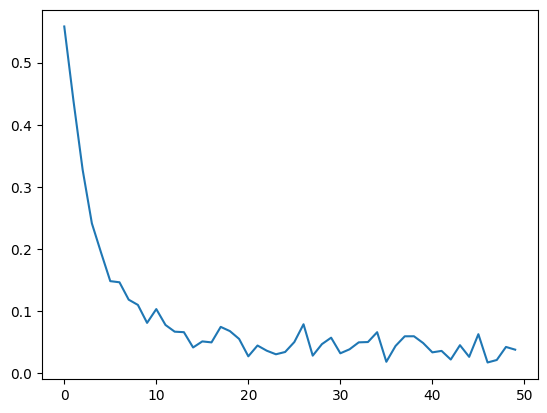

In [19]:
plt.plot(Loss)

In [21]:
# X_test_ts.to(device)는 테스트 데이터를 현재 설정된 디바이스(CPU 또는 GPU)로 이동
# 예측을 수행하고, 결과를 CPU로 다시 이동시킨 후 numpy 배열로 변환
# .detach()는 계산 그래프에서 예측값을 분리하여 그래디언트가 필요없는 텐서로 만듭니다.
# 텐서를 NumPy 배열로 변환합니다.
#  > 0.5 조건을 사용하여 모델의 출력(확률)을 이진 분류 결정(0 또는 1)으로 변환
y_pred = model(X_test_ts.to(device)).cpu().detach().numpy() > 0.5

In [22]:
sum(y_test == y_pred.flatten()) / len(y_test)

0.9855